In [1]:
import os
import random
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import pandas as pd
from glob import glob

In [2]:
import os

# Dataset path
BASE_PATH = "/kaggle/input/sh17-dataset-for-ppe-detection"
print(os.listdir(BASE_PATH))

['labels', 'train_files.txt', 'images', 'meta-data', 'val_files.txt', 'voc_labels']


In [3]:
# Paths
IMAGES_PATH = os.path.join(BASE_PATH, "images")
LABELS_PATH = os.path.join(BASE_PATH, "labels")
TRAIN_FILES = os.path.join(BASE_PATH, "train_files.txt")
VAL_FILES = os.path.join(BASE_PATH, "val_files.txt")

In [4]:
def list_files_in_folder(folder_path, extension):
    """List all files with a specific extension in a folder."""
    return sorted(glob(os.path.join(folder_path, f"*.{extension}")))

In [5]:
def load_metadata(metadata_path):
    """Load metadata JSON file."""
    with open(metadata_path, 'r') as f:
        return json.load(f)

In [6]:
def load_label(label_path):
    """Load YOLO label file and parse it."""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    return [line.strip().split() for line in lines]

In [7]:
def analyze_class_distribution(labels_folder):
    """Analyze class distribution across all labels."""
    
    labels = list_files_in_folder(labels_folder, 'txt')
        
    class_instance_counter = Counter()
    class_image_counter = Counter()
  
    for label_file in labels:
        annotations = load_label(label_file)
        tmp_set = set()
        for annotation in annotations:
            class_id = annotation[0]
            class_instance_counter[class_id] += 1
            if class_id not in tmp_set : 
                class_image_counter[class_id] += 1
                tmp_set.add(class_id)
                
    # Create first DataFrame with instance counts
    df = pd.DataFrame(class_instance_counter.items(), columns=['Class_ID', 'Count Instances'])
    df['Class_ID'] = df['Class_ID'].astype(int)
    df = df.sort_values('Class_ID')
    
    # Create second DataFrame with image counts
    df_img_count = pd.DataFrame(class_image_counter.items(), columns=['Class_ID', 'Count Images'])
    df_img_count['Class_ID'] = df_img_count['Class_ID'].astype(int)
    df_img_count = df_img_count.sort_values('Class_ID')
    
    # Merge the DataFrames on Class_ID
    combined_df = pd.merge(df, df_img_count, on='Class_ID', how='outer')
    
    # Sort by Class_ID and reset index
    combined_df = combined_df.sort_values('Class_ID').reset_index(drop=True)
    
    return combined_df

In [8]:
class_df = analyze_class_distribution(LABELS_PATH)
class_df.head()

Class_ID  Count Instances  Count Images
0         0            13802          7617
1         1             7730          4884
2         2              318           223
3         3             8950          5646
4         4              134           127

In [9]:
def plot_class_distribution(df, class_names, figsize=(12, 6)):
    """Plot class distribution with percentages and colors."""
    # Calculate percentages
    total = df['Count'].sum()
    df['Percentage'] = (df['Count'] / total * 100).round(1)
    
    # Sort the DataFrame by counts in descending order
    df = df.sort_values('Count', ascending=False)
    
    # Map class IDs to their names
    df['Class_Name'] = df['Class_ID'].map(lambda x: class_names[int(x)])
    
    # Create the plot
    plt.figure(figsize=figsize)
    colors = sns.color_palette("husl", len(df))  
    barplot = sns.barplot(
        x='Class_Name', 
        y='Count', 
        data=df, 
        palette=colors
    )
    
    # Add percentage labels above the bars
    for i, row in enumerate(df.itertuples()):
        barplot.text(
            i, 
            row.Count + total * 0.003,  
            f"{row.Percentage}%", 
            ha='center', 
            fontsize=10, 
            color='black'
        )
    
    # Add labels and title
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Instances", fontsize=12)
    plt.title("Class Distribution with Percentages", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

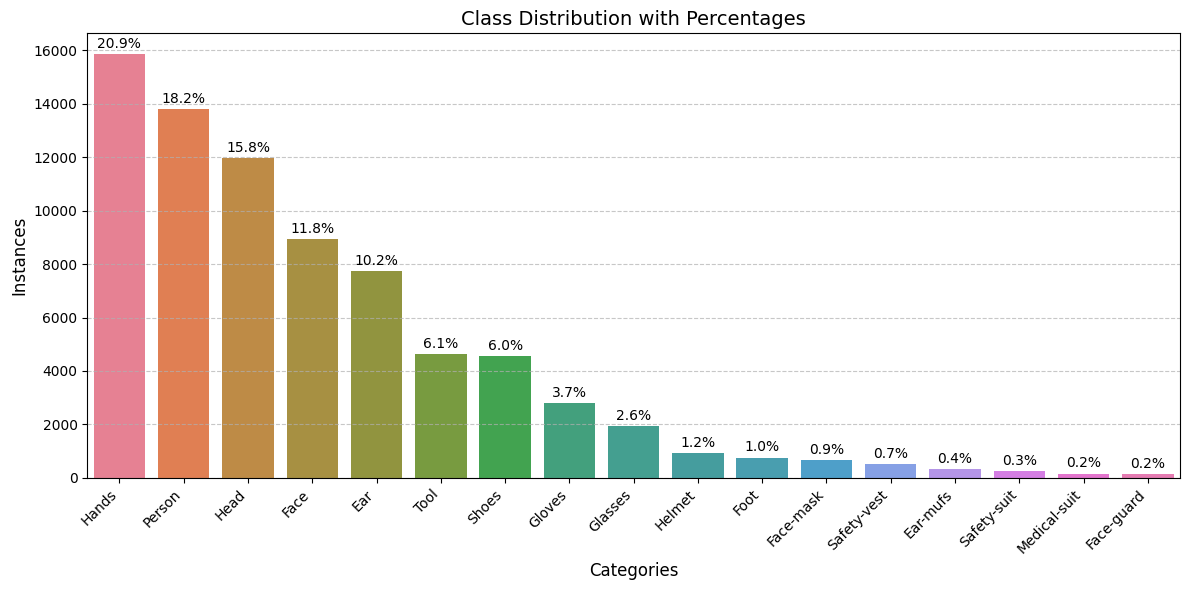

In [10]:
class_names = [
    "Person", "Ear", "Ear-mufs", "Face", "Face-guard", "Face-mask",
    "Foot", "Tool", "Glasses", "Gloves", "Helmet", "Hands", "Head",
    "Medical-suit", "Shoes", "Safety-suit", "Safety-vest"
]
plot_class_distribution(class_df.rename(columns={'Count Instances': 'Count'}), class_names)

In [11]:
def visualize_annotations(image_path, label_path, title=''):
    """Display an image with its bounding boxes."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    annotations = load_label(label_path)
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation)
        h, w, _ = img.shape
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)
        
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, str(int(class_id)), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

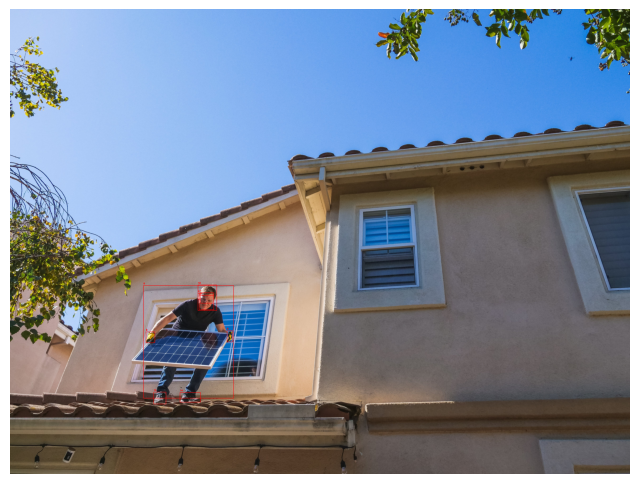

In [12]:
sample_image = f'{IMAGES_PATH}/pexels-photo-9875414.jpeg'
sample_label = f'{LABELS_PATH}/pexels-photo-9875414.txt'
visualize_annotations(sample_image, sample_label)

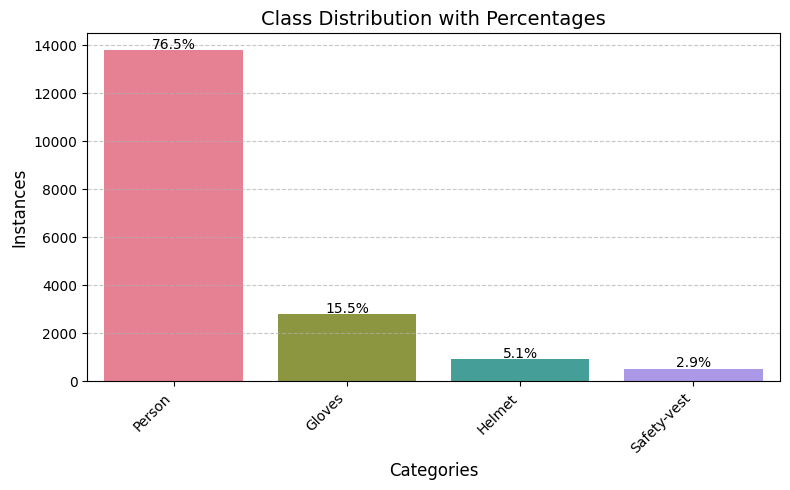

In [13]:
filtered_df = class_df[class_df['Class_ID'].isin([0, 9, 10, 16])].copy()
plot_class_distribution(filtered_df.rename(columns={'Count Instances': 'Count'}), class_names, figsize=(8, 5))

In [14]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/kaggle/working/dataset/images/train", exist_ok=True)
os.makedirs("/kaggle/working/dataset/images/val", exist_ok=True)
os.makedirs("/kaggle/working/dataset/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/dataset/labels/val", exist_ok=True)

# Classes to retain: person (0), helmet (10), safety-vest (16)
TARGET_CLASSES = [0, 9, 10, 16]

# Helper function to filter labels and move corresponding images
def filter_and_move(file_list, dest_images, dest_labels):
    with open(file_list, "r") as f:
        file_names = f.read().strip().split("\n")
    number_skip, number_move = 0, 0
    
    for file_name in file_names:
        base_name = os.path.splitext(file_name)[0]
        
        # Paths for source image and label
        img_src = os.path.join(IMAGES_PATH, file_name)
        label_src = os.path.join(LABELS_PATH, f"{base_name}.txt")
        
        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        # Read and filter label file
        filtered_lines = []
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                if int(class_id) in TARGET_CLASSES:
                    # Map old class ID to new class ID (0, 1, 2)
                    new_class_id = TARGET_CLASSES.index(int(class_id))
                    filtered_lines.append(f"{new_class_id} {' '.join(bbox)}\n")  # Added \n here
        
        # Skip if no valid annotations remain
        if len(filtered_lines) == 0:
            number_skip += 1
            continue
            
        number_move += 1
        
        # Save filtered label
        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        with open(label_dest, "w") as outfile:
            outfile.writelines(filtered_lines)  # Now each line has proper line ending
        
        # Copy corresponding image
        shutil.copy2(img_src, os.path.join(dest_images, file_name))  # Fixed image copy path
    
    print(f"{number_skip} images skipped, and {number_move} were moved")

In [15]:
# Process training and validation datasets
filter_and_move(TRAIN_FILES, 
                "/kaggle/working/dataset/images/train", 
                "/kaggle/working/dataset/labels/train")

300 images skipped, and 6179 were moved


In [16]:
filter_and_move(VAL_FILES, 
                "/kaggle/working/dataset/images/val", 
                "/kaggle/working/dataset/labels/val")

80 images skipped, and 1540 were moved


In [17]:
filtered_class_df = analyze_class_distribution('/kaggle/working/dataset/labels/train')
filtered_class_df.head()

Class_ID  Count Instances  Count Images
0         0            11068          6102
1         1             2261          1067
2         2              773           373
3         3              433           168

In [18]:
filtered_class_df_val = analyze_class_distribution('/kaggle/working/dataset/labels/val')
filtered_class_df_val.head()

Class_ID  Count Instances  Count Images
0         0             2734          1515
1         1              529           254
2         2              154            93
3         3               97            45

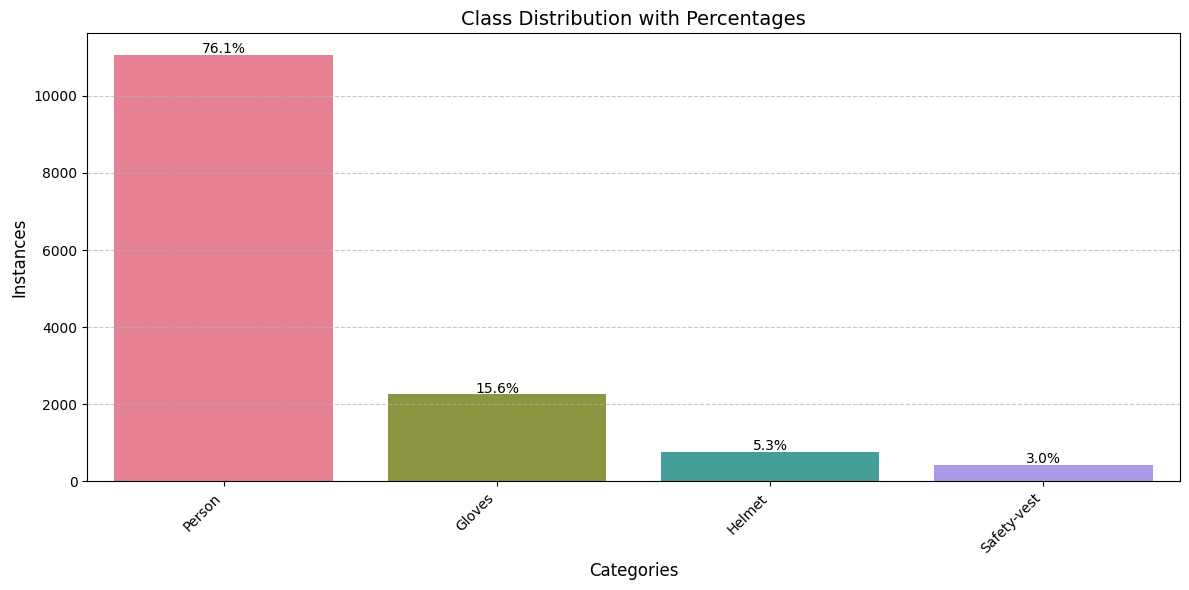

In [19]:
safety_class_names = [
    "Person", "Gloves", "Helmet","Safety-vest"
]
plot_class_distribution(filtered_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

In [20]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/kaggle/working/undersampled_dataset/images/train", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/images/val", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/labels/val", exist_ok=True)

def undersampled_person_data( images_path, labels_path, dest_images, dest_labels, person_count):
    
    file_names = os.listdir(images_path)
    
    i= 0
    for file_name in file_names:
        
        base_name = os.path.splitext(file_name)[0]
        
        # Paths for source image and label
        img_src = os.path.join(images_path, file_name)
        label_src = os.path.join(labels_path, f"{base_name}.txt")
        
        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        filtered_lines = set()
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                filtered_lines.add(int(class_id))
                
        filtered_lines = list(filtered_lines)            
        
        if len(filtered_lines) == 1 and filtered_lines[0] == 0 and i>= person_count:
            continue
        if len(filtered_lines) == 1 and filtered_lines[0] == 0:
            i+=1
         
        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        shutil.copy2(label_src, label_dest)
        
        # Copy corresponding image
        shutil.copy2(img_src, dest_images)
        

In [21]:
undersampled_person_data("/kaggle/working/dataset/images/train", 
                "/kaggle/working/dataset/labels/train", 
                "/kaggle/working/undersampled_dataset/images/train", 
                "/kaggle/working/undersampled_dataset/labels/train", 90)

In [22]:
undersampled_class_df = analyze_class_distribution('/kaggle/working/undersampled_dataset/labels/train')
undersampled_class_df.head()

Class_ID  Count Instances  Count Images
0         0             2718          1274
1         1             2261          1067
2         2              773           373
3         3              433           168

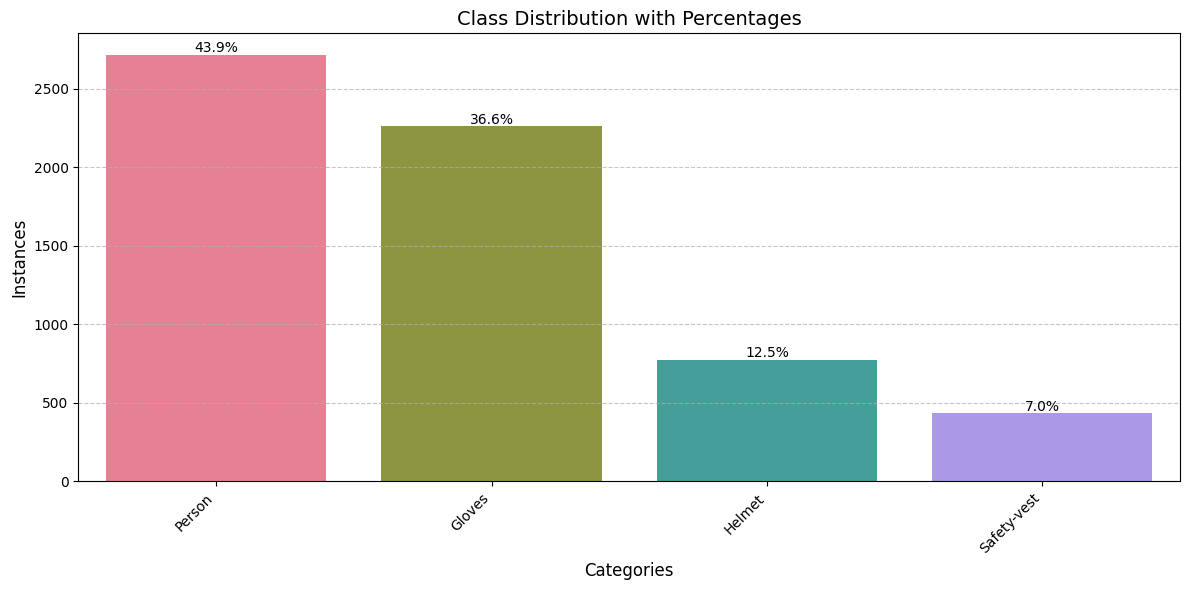

In [23]:
plot_class_distribution(undersampled_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

In [24]:
undersampled_person_data("/kaggle/working/dataset/images/val", 
                "/kaggle/working/dataset/labels/val", 
                "/kaggle/working/undersampled_dataset/images/val", 
                "/kaggle/working/undersampled_dataset/labels/val", 30)

In [25]:
undersampled_class_df_val = analyze_class_distribution('/kaggle/working/undersampled_dataset/labels/val')
undersampled_class_df_val.head()

Class_ID  Count Instances  Count Images
0         0              602           307
1         1              529           254
2         2              154            93
3         3               97            45

In [26]:
%pip install ultralytics==8.0.38

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nv

In [27]:
data_yaml = """
train: /kaggle/working/undersampled_dataset/images/train
val: /kaggle/working/undersampled_dataset/images/val
names:
  0: person
  1: gloves
  2: helmet
  3: safety-vest
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(data_yaml)

In [28]:
import torch

# Monkey-patch torch.load to override weights_only
_original_load = torch.load
def patched_load(*args, **kwargs):
    kwargs["weights_only"] = False
    return _original_load(*args, **kwargs)
torch.load = patched_load

In [30]:
from ultralytics import YOLO

# Load the model (will now use the patched torch.load)
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 108MB/s]


In [31]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
Device Name: Tesla P100-PCIE-16GB


In [32]:
model.train(data="/kaggle/working/data.yaml",\
            project="/kaggle/working/runs",\
            batch = 4, epochs=30, imgsz = 640, cache=True)

Ultralytics YOLOv8.0.38 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/working/data.yaml, epochs=30, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/kaggle/working/runs, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, 

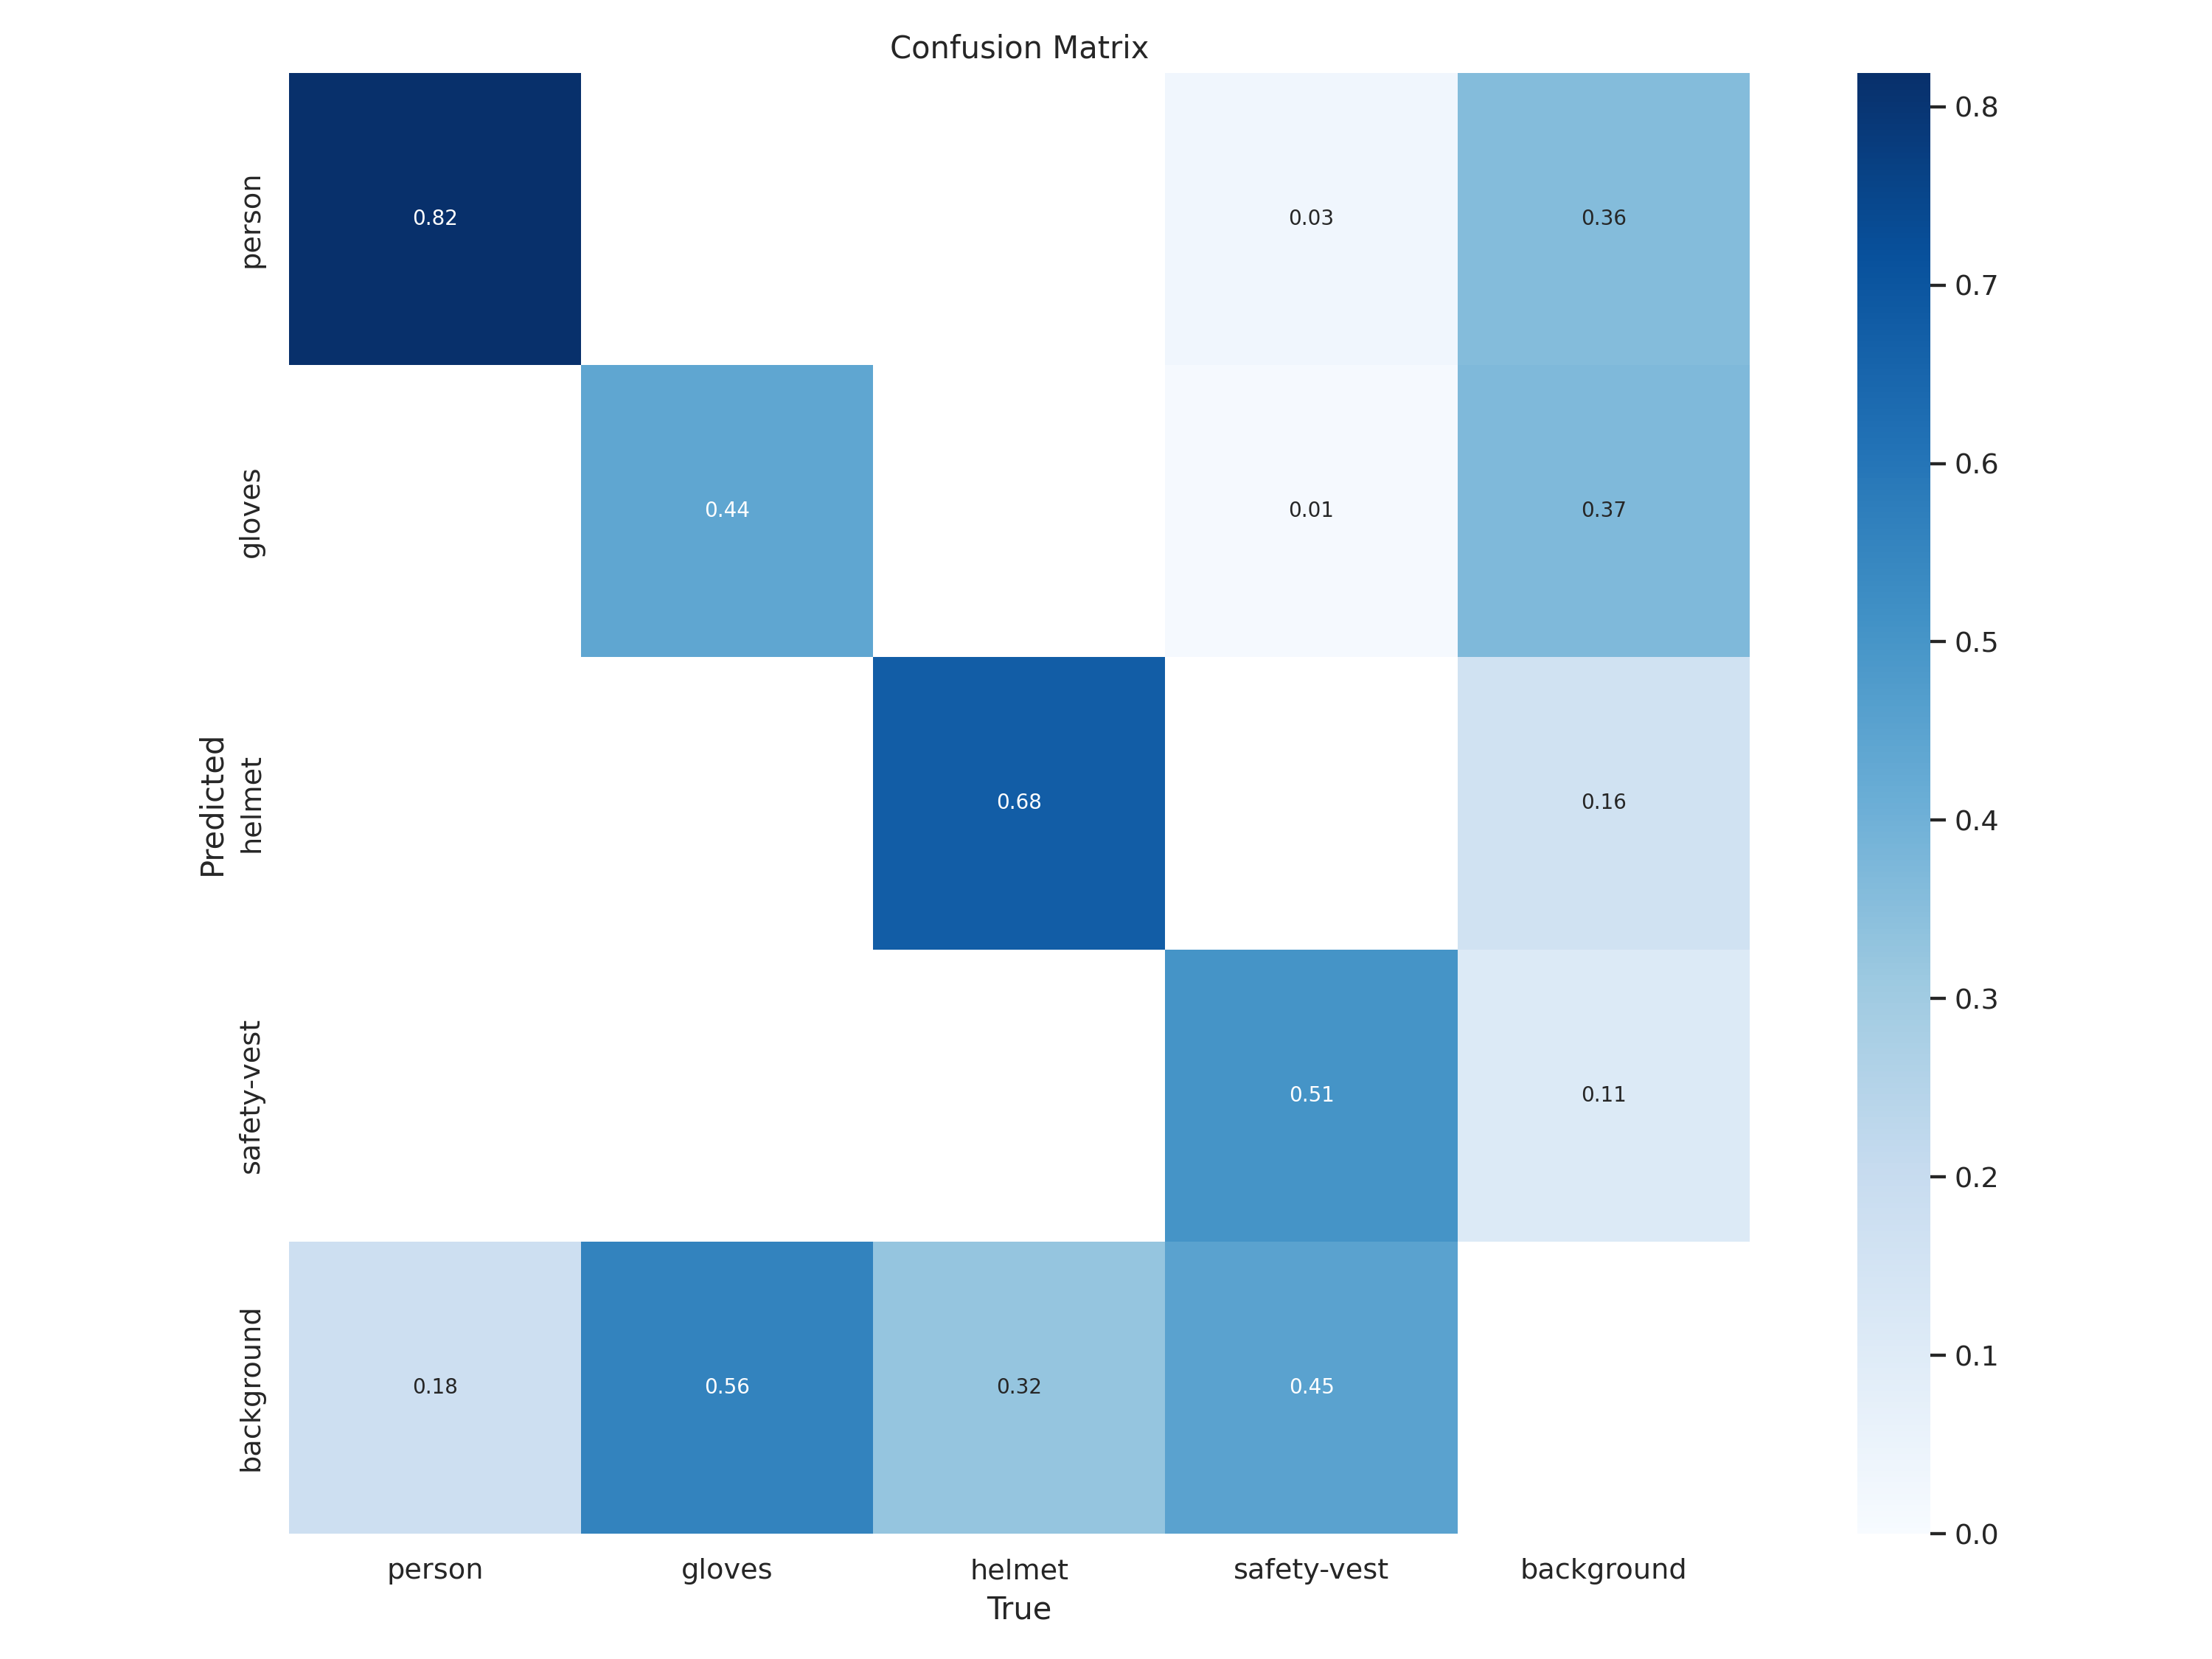

In [33]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/train/confusion_matrix.png', width=800)

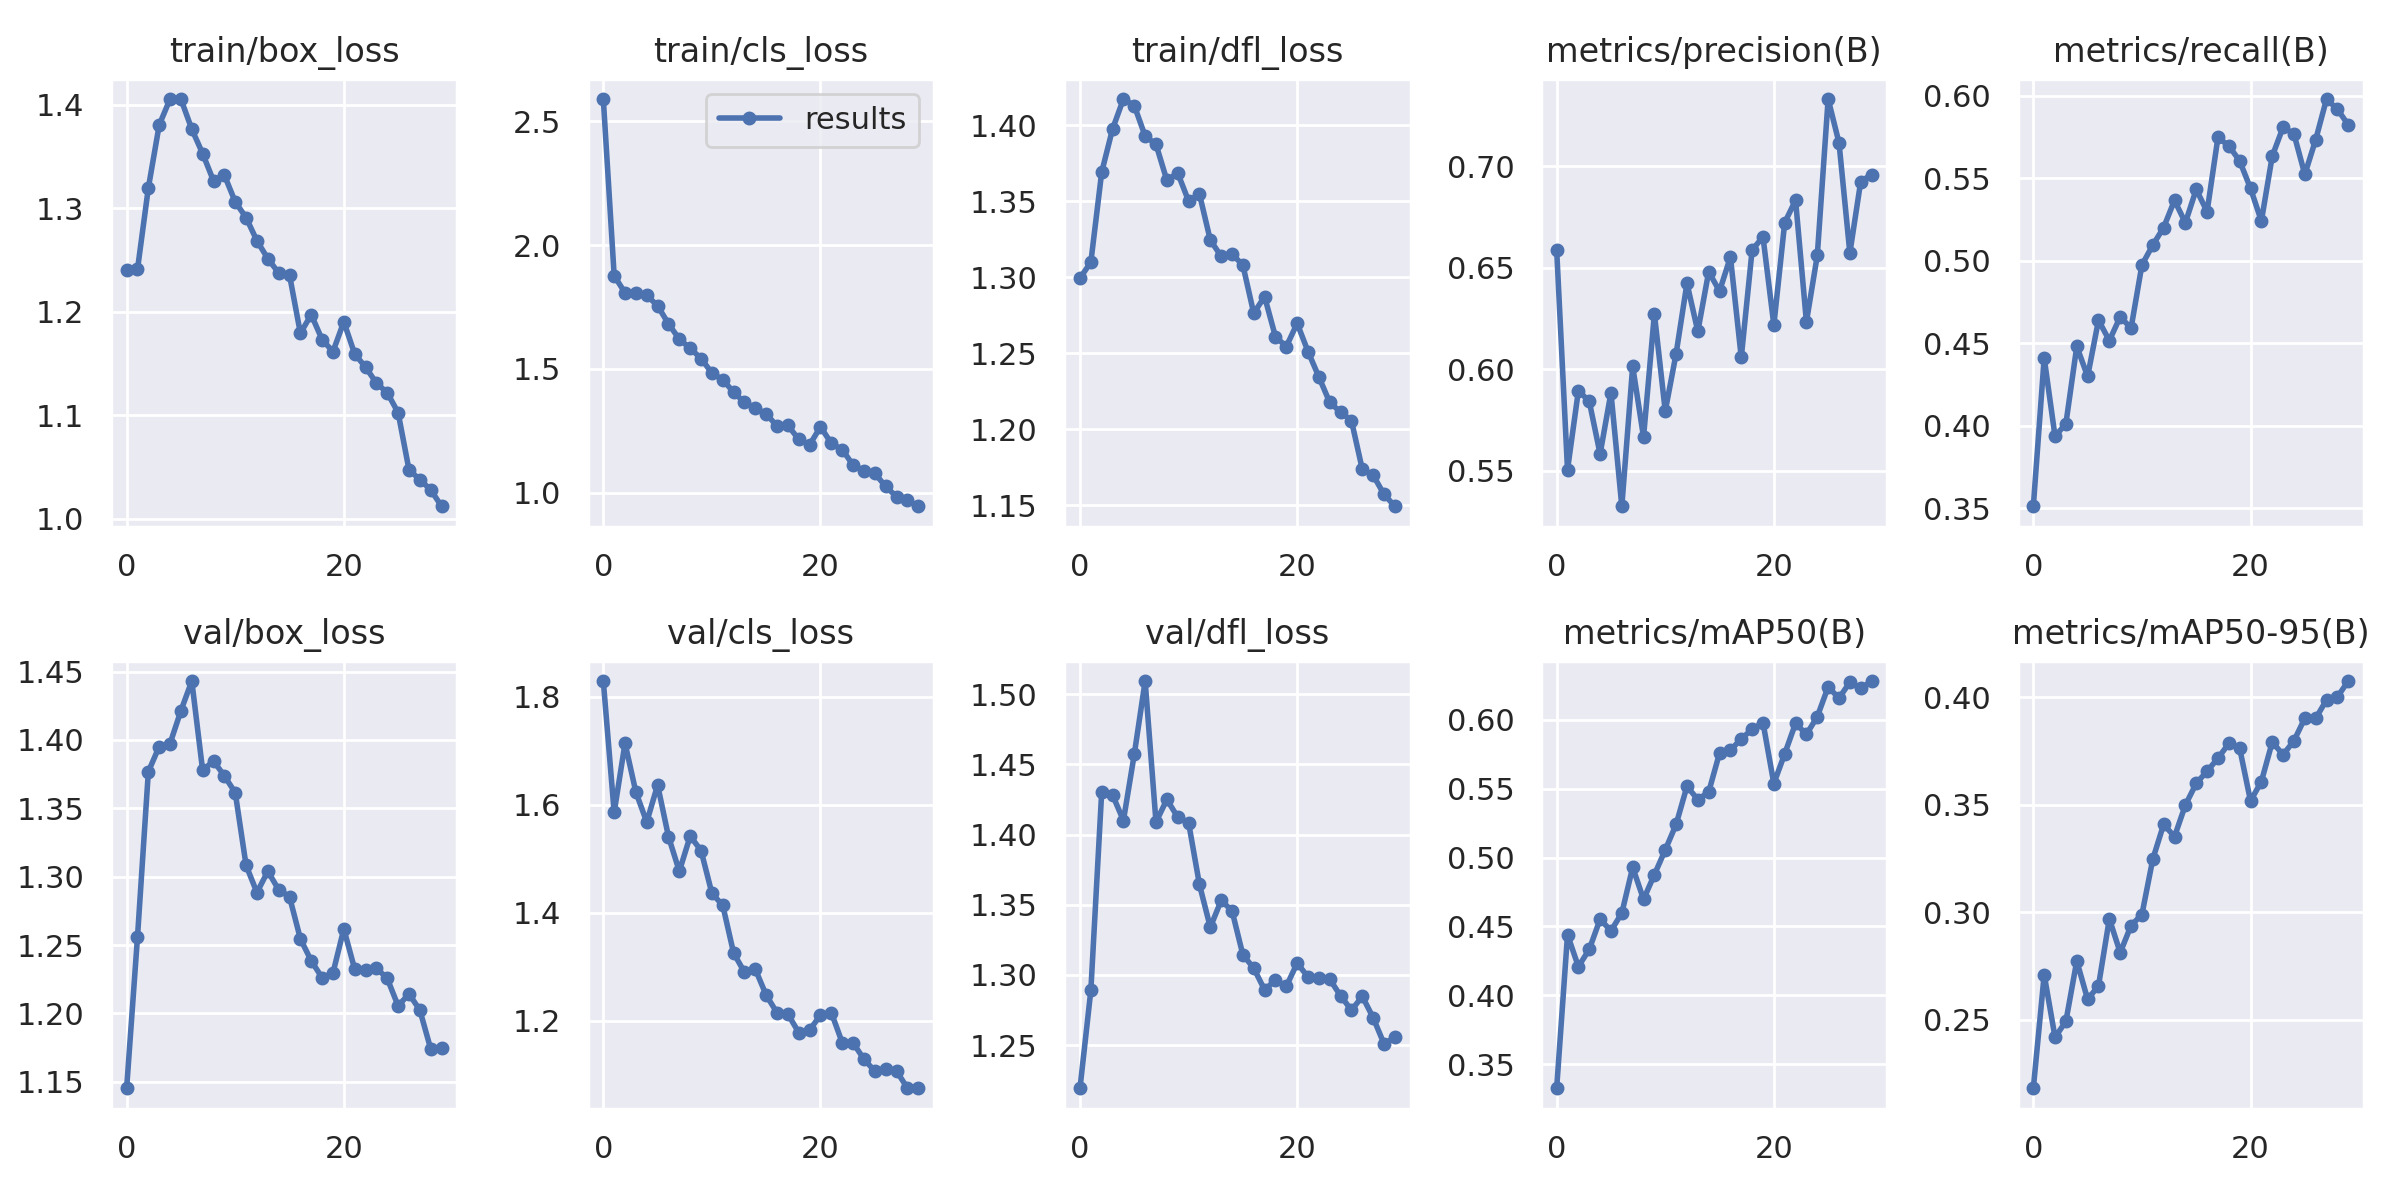

In [34]:
Image(filename='/kaggle/working/runs/train/results.png', width=800)

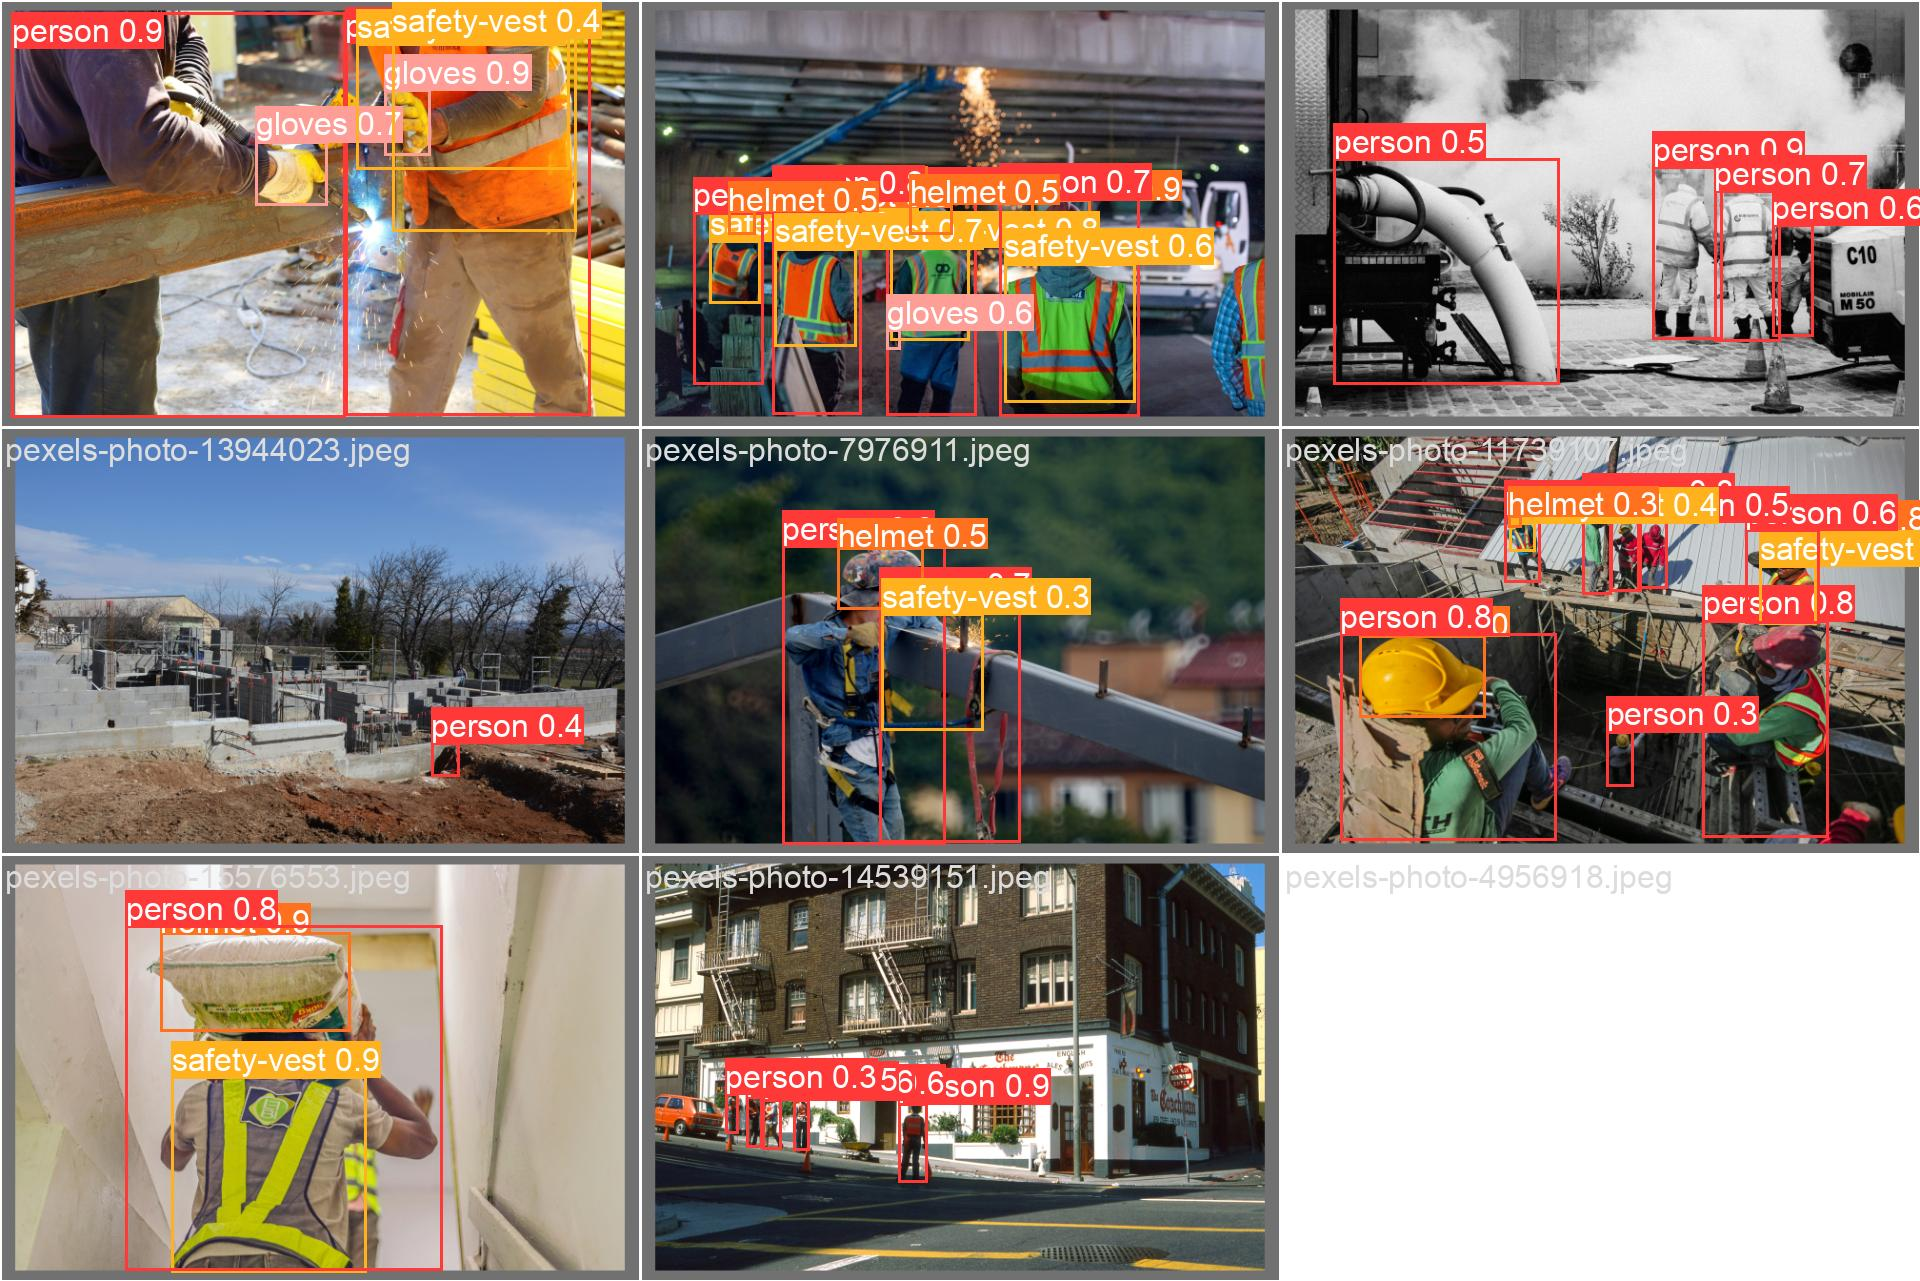

In [35]:
Image(filename='/kaggle/working/runs/train/val_batch2_pred.jpg', width=800)

Ultralytics YOLOv8.0.38 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /kaggle/input/safety-helmet-test-dataset/test_dataset/test_image.jpeg: 384x640 2 persons, 2 glovess, 2 helmets, 3 safety-vests, 37.6ms
Speed: 0.5ms pre-process, 37.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


9 bounding boxes drawn.


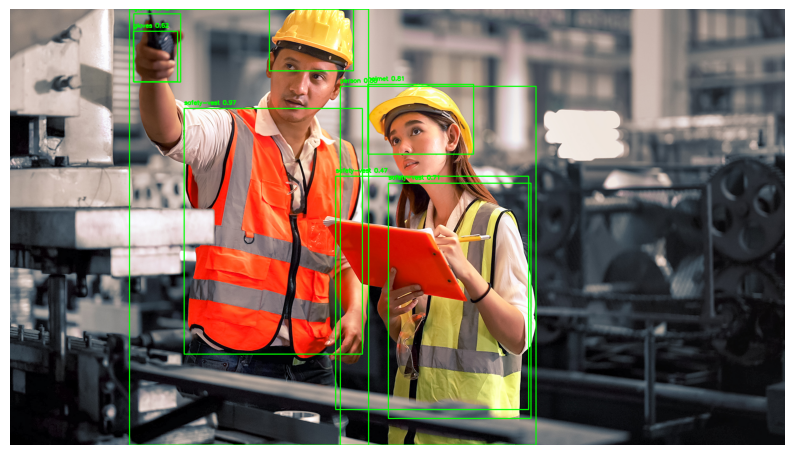

In [36]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to the image
test_image_path = '/kaggle/input/safety-helmet-test-dataset/test_dataset/test_image.jpeg'

# Perform inference
results = model.predict(source=test_image_path, conf=0.25)  

# Check if results are available
if not results:
    print("No detection results found.")
    exit()

# Load the image
image = cv2.imread(test_image_path)

# Ensure the image is loaded
if image is None:
    raise ValueError("Failed to load the image. Check the file path.")

# Draw bounding boxes on the image
boxes_drawn = 0
for result in results:
    if not result.boxes:
        print("No bounding boxes detected.")
        continue

    for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        x1, y1, x2, y2 = map(int, box)  # Bounding box coordinates
        confidence = float(conf)  # Confidence score
        class_id = int(cls)  # Class ID
        label = f"{model.names[class_id]} {confidence:.2f}"

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Put the label on the image
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        boxes_drawn += 1

# Check if any boxes were drawn
if boxes_drawn == 0:
    print("No bounding boxes were drawn. Try lowering the confidence threshold or using a different image.")
else:
    print(f"{boxes_drawn} bounding boxes drawn.")

# Convert the image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

In [37]:
test_video_path = '/kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4'

# Run the model on the video
results = model.predict(source=test_video_path, conf=0.25, save=True)


video 1/1 (1/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x640 2 persons, 2 helmets, 1 safety-vest, 7.0ms
video 1/1 (2/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x640 2 persons, 2 helmets, 1 safety-vest, 7.0ms
video 1/1 (3/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x640 2 persons, 2 helmets, 1 safety-vest, 7.0ms
video 1/1 (4/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x640 2 persons, 2 helmets, 1 safety-vest, 7.6ms
video 1/1 (5/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x640 2 persons, 2 helmets, 1 safety-vest, 10.4ms
video 1/1 (6/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x640 2 persons, 2 helmets, 1 safety-vest, 7.1ms
video 1/1 (7/314) /kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4: 384x64

In [43]:
!ffmpeg -i "/kaggle/working/runs/predict/Safety Helmet Videos.mp4" -vf "scale=1280:720" -crf 28 -preset fast "/kaggle/working/runs/predict/compressed_video.mp4"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [44]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

play('/kaggle/working/runs/predict/compressed_video.mp4')